# KNN dan Kmeans

## Understanding data

Dalam kerangka kerja CRISP-DM (Cross Industry Standard Process for Data Mining), tahap Data Understanding merupakan langkah kedua setelah Business Understanding. Tujuannya adalah untuk memahami data yang dimiliki secara menyeluruh sebelum masuk ke tahap pemodelan

### Pengumpulan Data

Pada tahap ini kita mengumpulkan data menarik data dari sumber data ke dalam power BI untuk dijadikan satu kemudian dianalisis. Pada kali ini kita akan melakukan pengumpulan data Iris dari database server Aiven dari posgre dan mysql dimana data di posgre dengan kolom sepal length dan sepal widt akan dijadikan satu dengan data mysql dengan kolom petal length dan sepal length menggunakan Script Python

1. Install psycopg2 di Python environment yang dipakai Power BI untuk melakukan deteksi outlier menggunakan KNN dan klastering dengan K-means
  
    pip install psycopg2-binary pandas



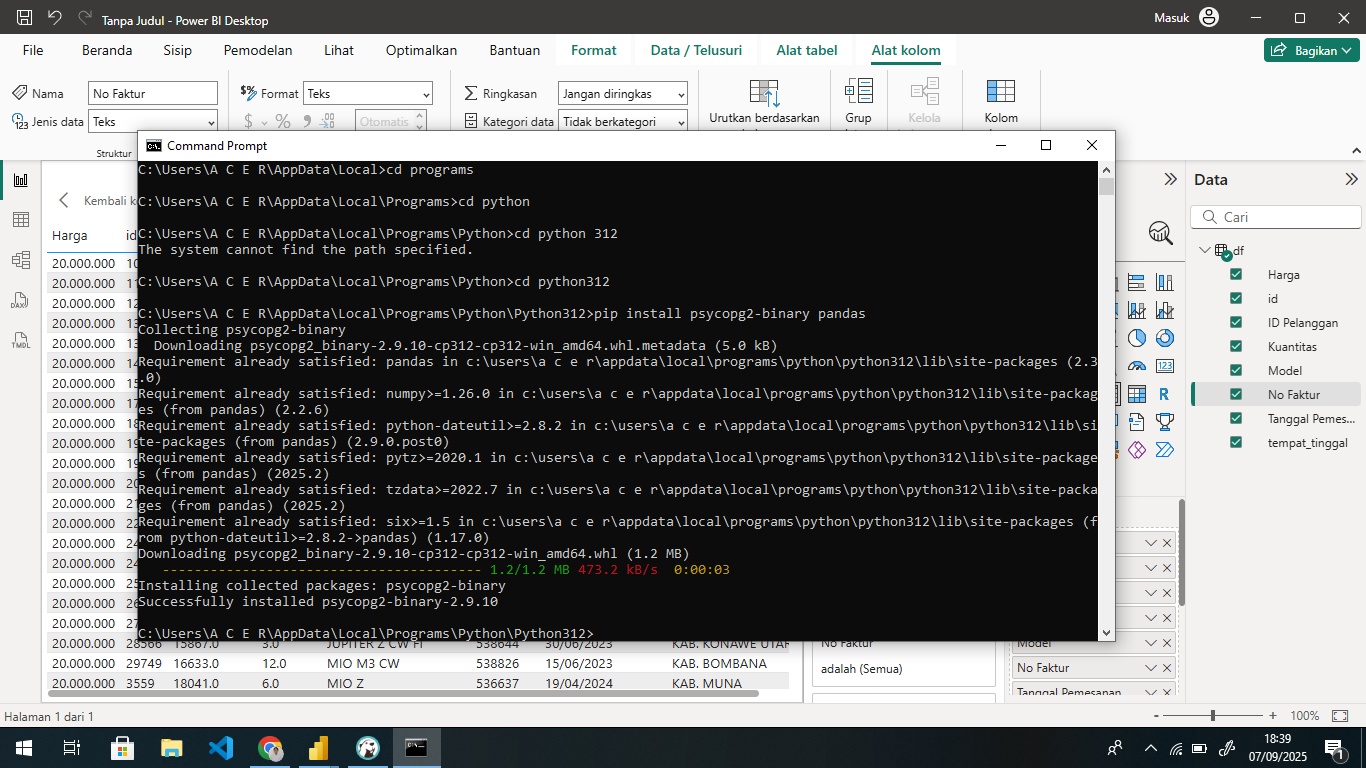

2. Buka power BI dan pilih dapatkan data dari sumber lain

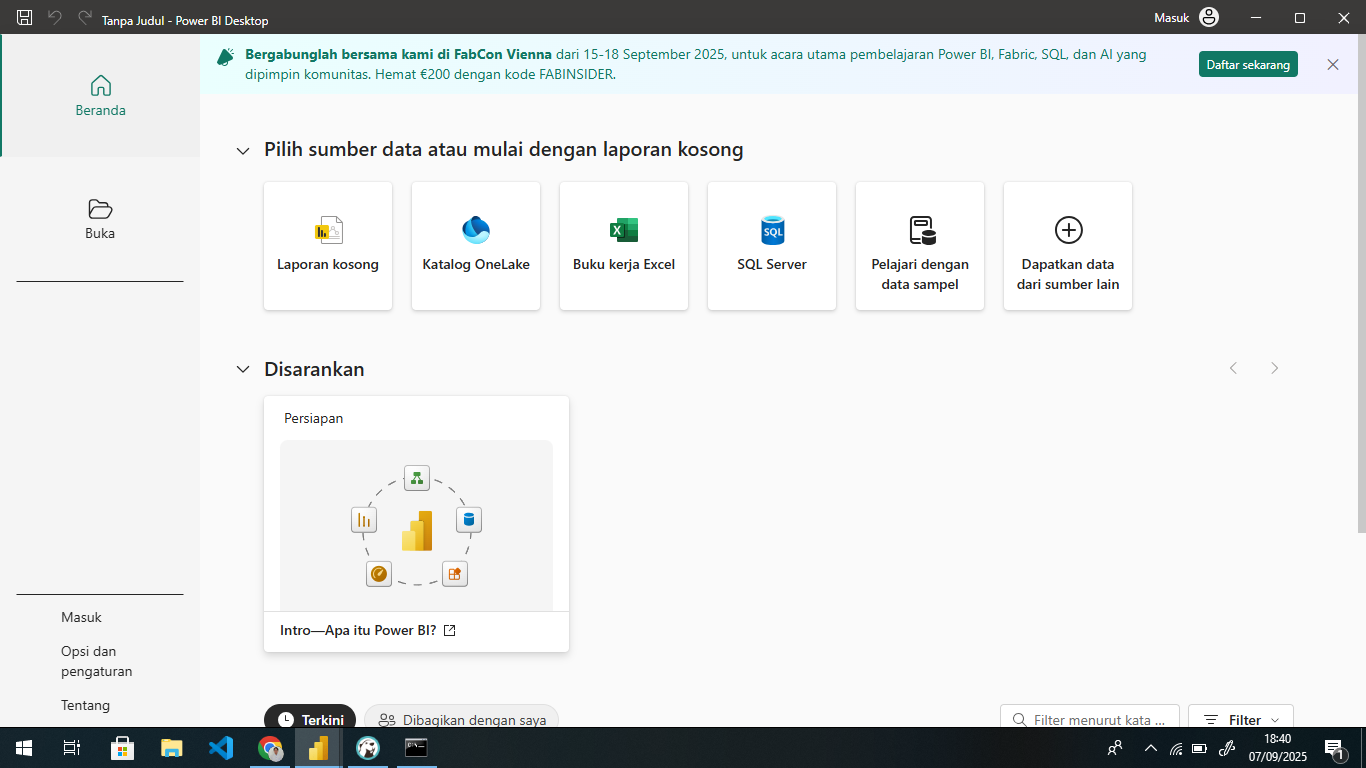

3. Cari Menu Skrip Python pada bar pencarian

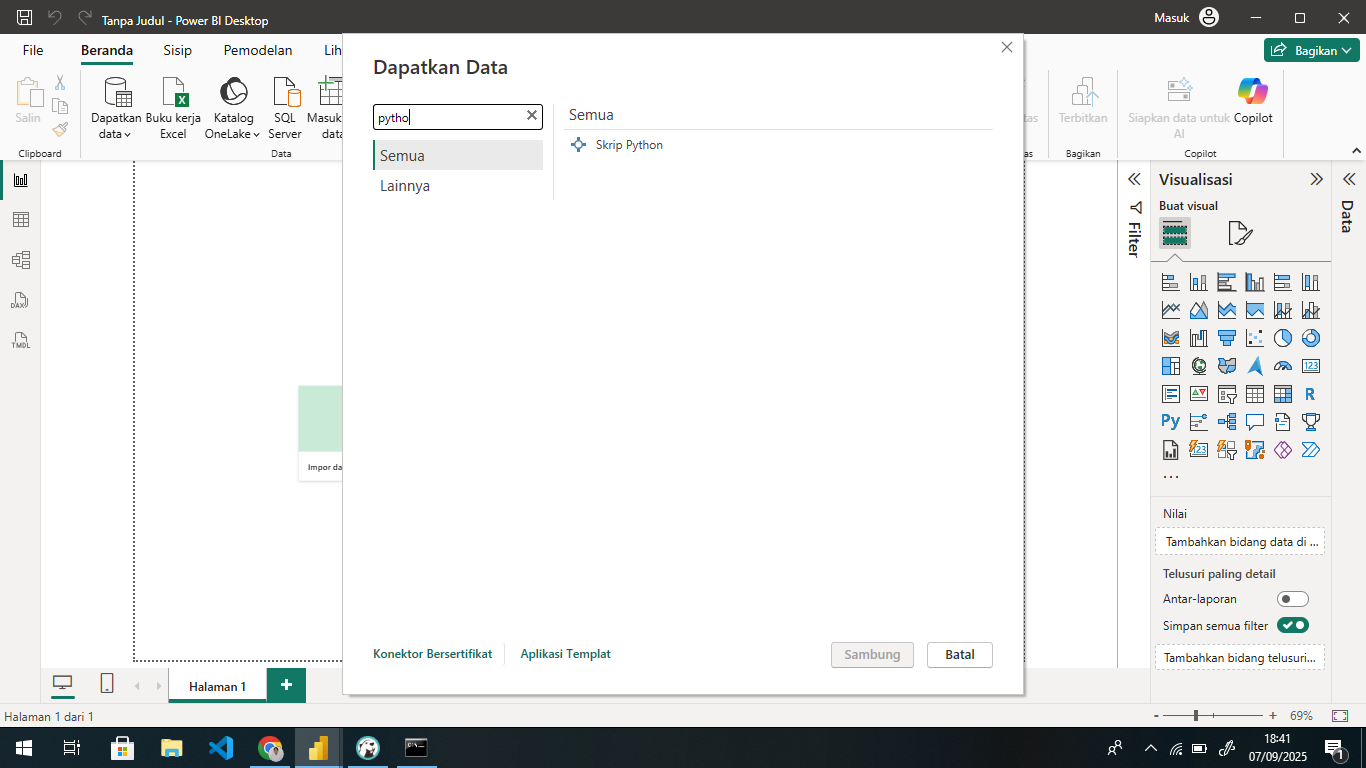

4. Coppy script Python dibawah masukkan kedalam script power BI

In [ ]:
import pandas as pd
import psycopg2

# Konfigurasi database
PG_HOST = "posgesqlpendata23-175-posgresqlpendata23-175.h.aivencloud.com"
PG_PORT = "17047"
PG_NAME = "defaultdb"
PG_USER = "avnadmin"
PG_PASS = "AVNS_XfGwRG6_6e5BdqZXovg"

# Koneksi ke PostgreSQL
conn = psycopg2.connect(
    host=PG_HOST,
    port=PG_PORT,
    dbname=PG_NAME,
    user=PG_USER,
    password=PG_PASS,
    sslmode="require"   # penting untuk koneksi Aiven
)

# Query ambil data (ubah nama_tabel sesuai dengan tabelmu)
query = "SELECT * FROM irisposgre.posgre"

# Load ke DataFrame
dataPosgre = pd.read_sql(query, conn)

# Tutup koneksi
conn.close()

# Output ke Power BI
dataPosgre

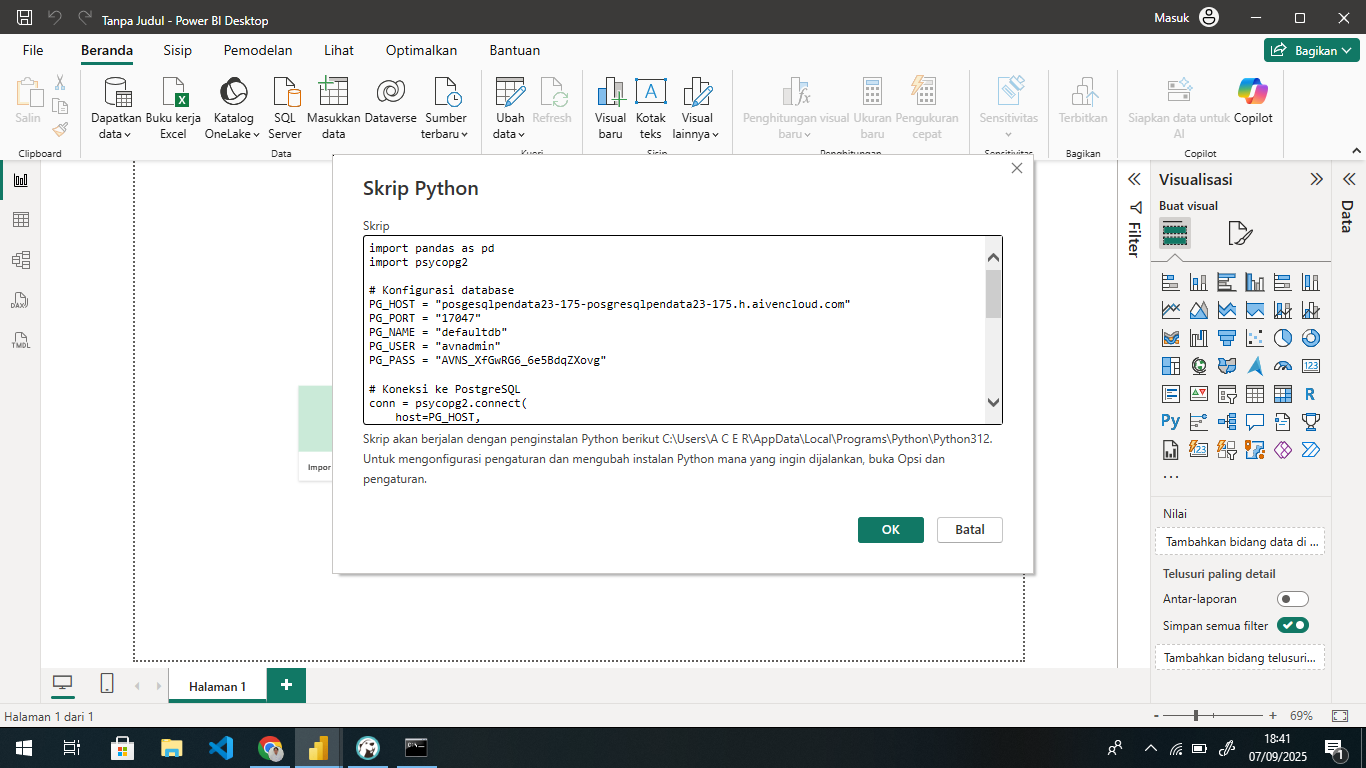

5. Klik Oke tunggu biarkan Power BI mengambil data dari server posgre ketika sudah selesai

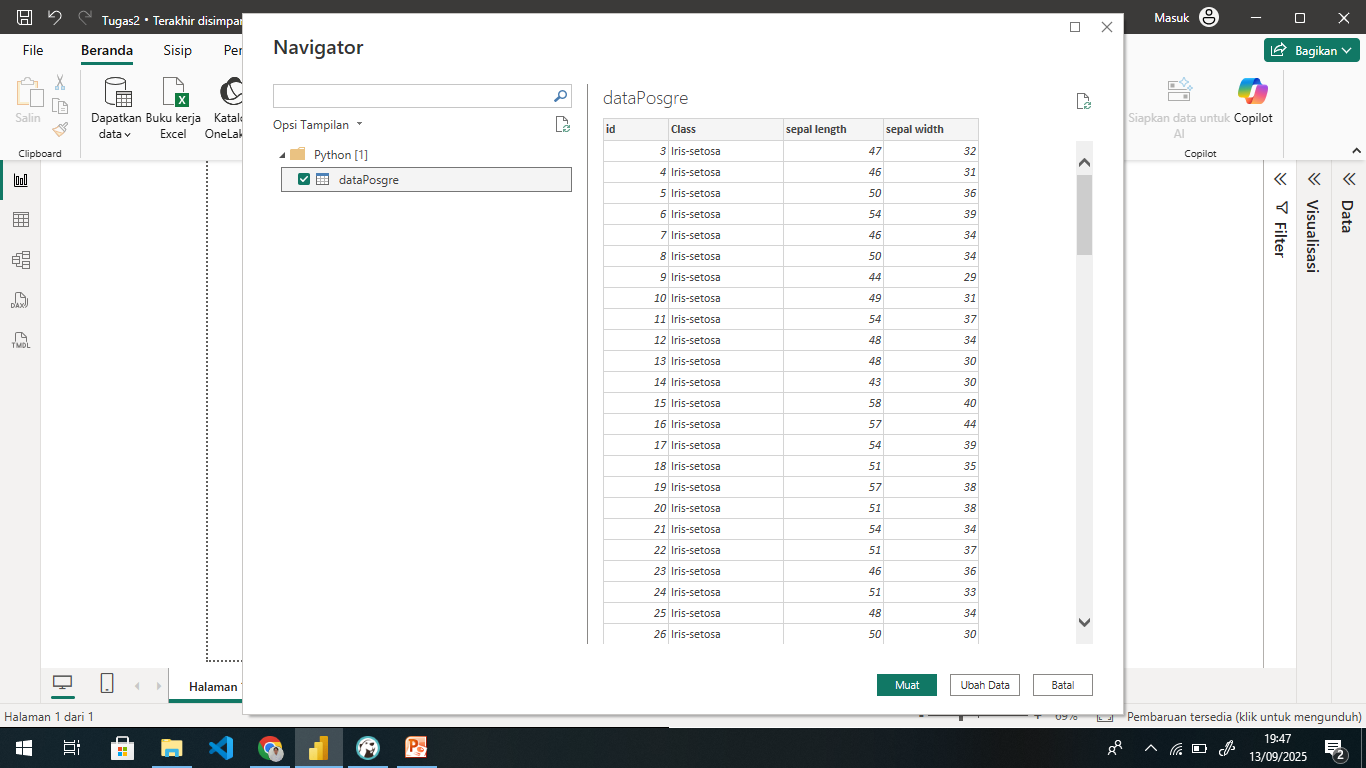

6. Klik ubah data untuk melakukan pengecekan pada data sesuaikan tipe data dengan isi data dengan mengklik icon didekat nama kolom

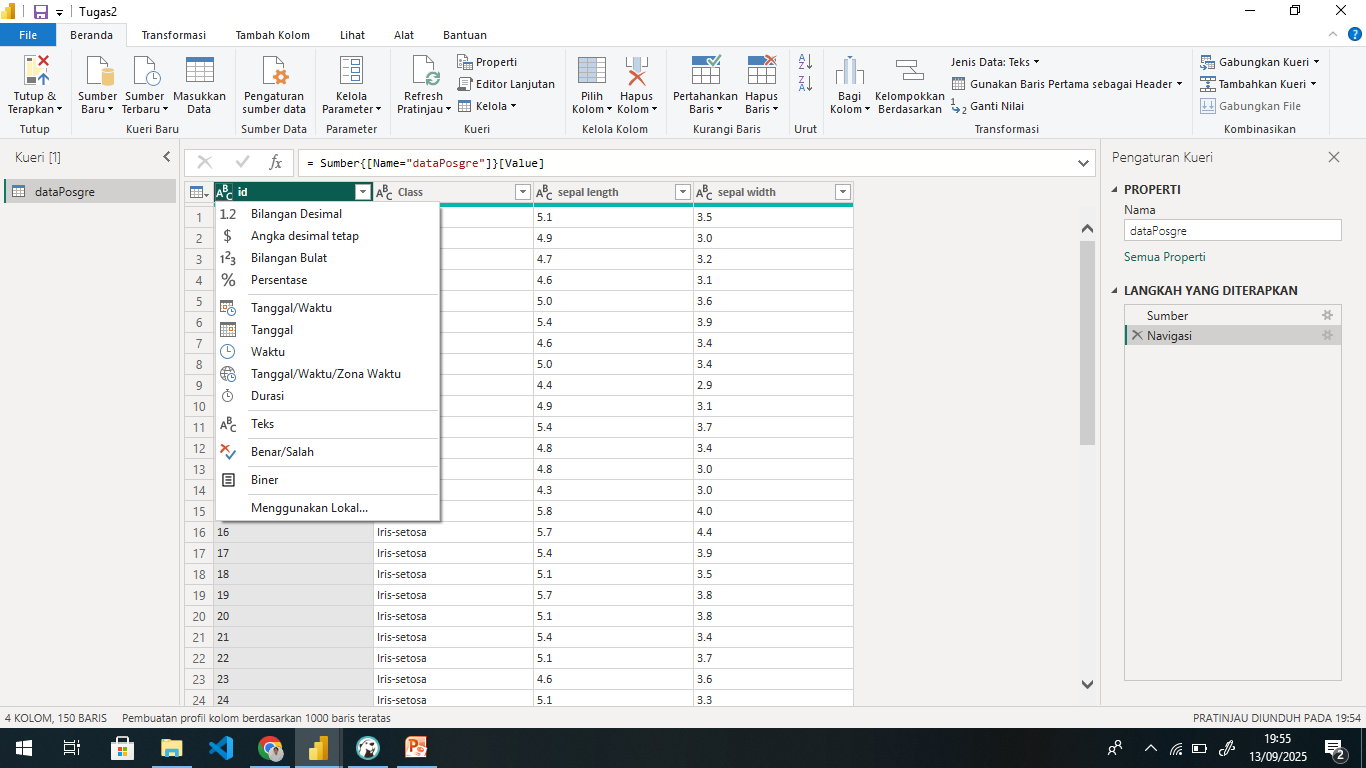

7. Jika semua data sudah sesuai kita bisa melakukan query kembali dengan mengklik sumber baru klik lainnya ulangin langkah 3 untuk memasukkan

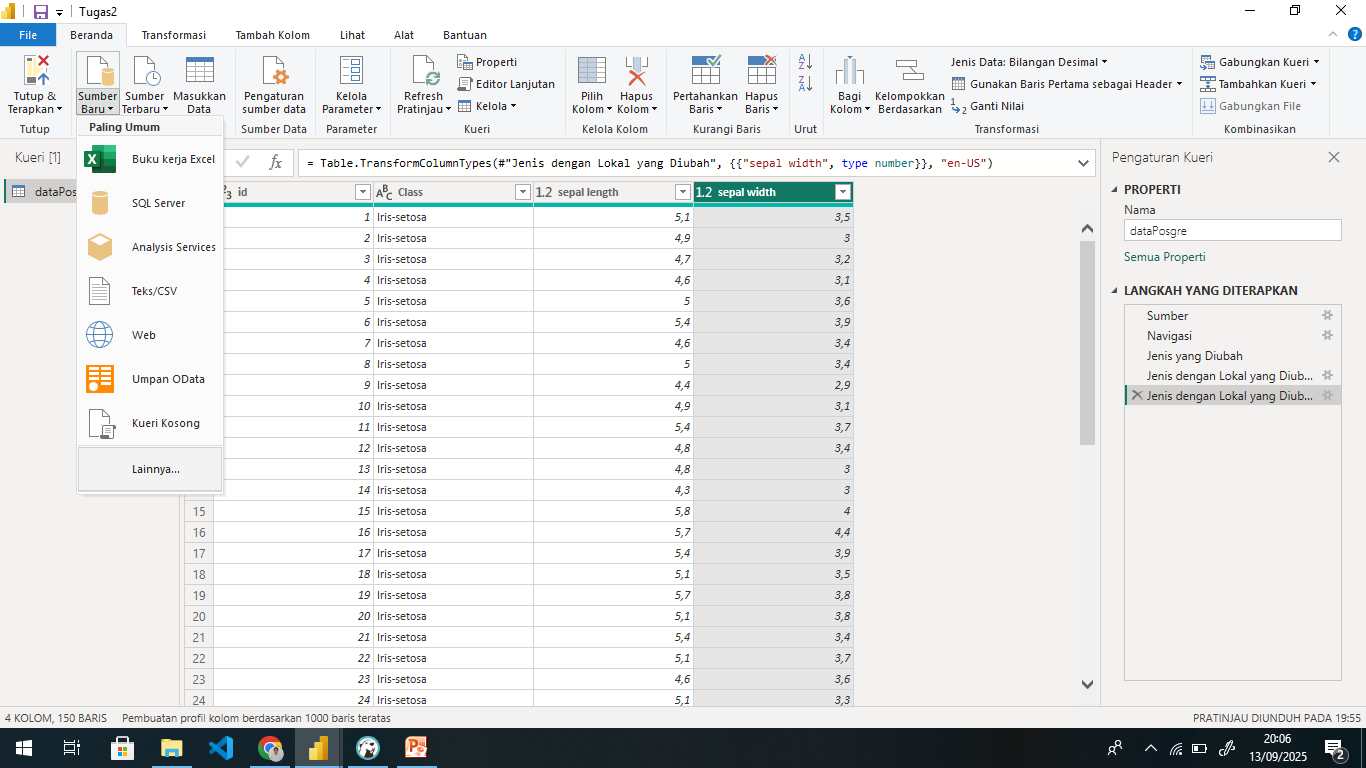

8. Salin Query tersebut untuk Mysql

In [ ]:
import pandas as pd
from sqlalchemy import create_engine

# Konfigurasi koneksi MySQL
DB_HOST = "mysql-pendata23-175-mysqlpendata23-175.g.aivencloud.com"
DB_PORT = 17974
DB_NAME = "defaultdb"
DB_USER = "avnadmin"
DB_PASS = "AVNS_756YWhIqpe1WzSKsGNx"

# Buat engine SQLAlchemy
engine = create_engine(
    f"mysql+pymysql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)

# Query ambil data
query = "SELECT * FROM irismysql.flowers ORDER BY id ASC;"
dataMysql = pd.read_sql(query, engine)

# Hapus baris header duplikat (jika ada)
dataMysql = dataMysql[dataMysql["id"] != "id"]

# Konversi kolom numerik ke tipe number
for col in ["petal length", "petal width"]:
    dataMysql[col] = pd.to_numeric(dataMysql[col], errors="coerce")

print(dataMysql.head())


   id        class  petal length  petal width
0   1  Iris-setosa           1.4          0.2
1   2  Iris-setosa           1.4          0.2
2   3  Iris-setosa           1.3          0.2
3   4  Iris-setosa           1.5          0.2
4   5  Iris-setosa           1.4          0.2
5   6  Iris-setosa           1.7          0.4
6   7  Iris-setosa           1.4          0.3
7   8  Iris-setosa           1.5          0.2
8   9  Iris-setosa           1.4          0.2
9  10  Iris-setosa           1.5          0.1


9. Jika 2 Table sudah terbenttuk data dari Mysql dan data dari Posgre selanjutnya gabungkan kedua table tersebut dengan duplikat table posgre dan klik editor lanjuta salin code berikut

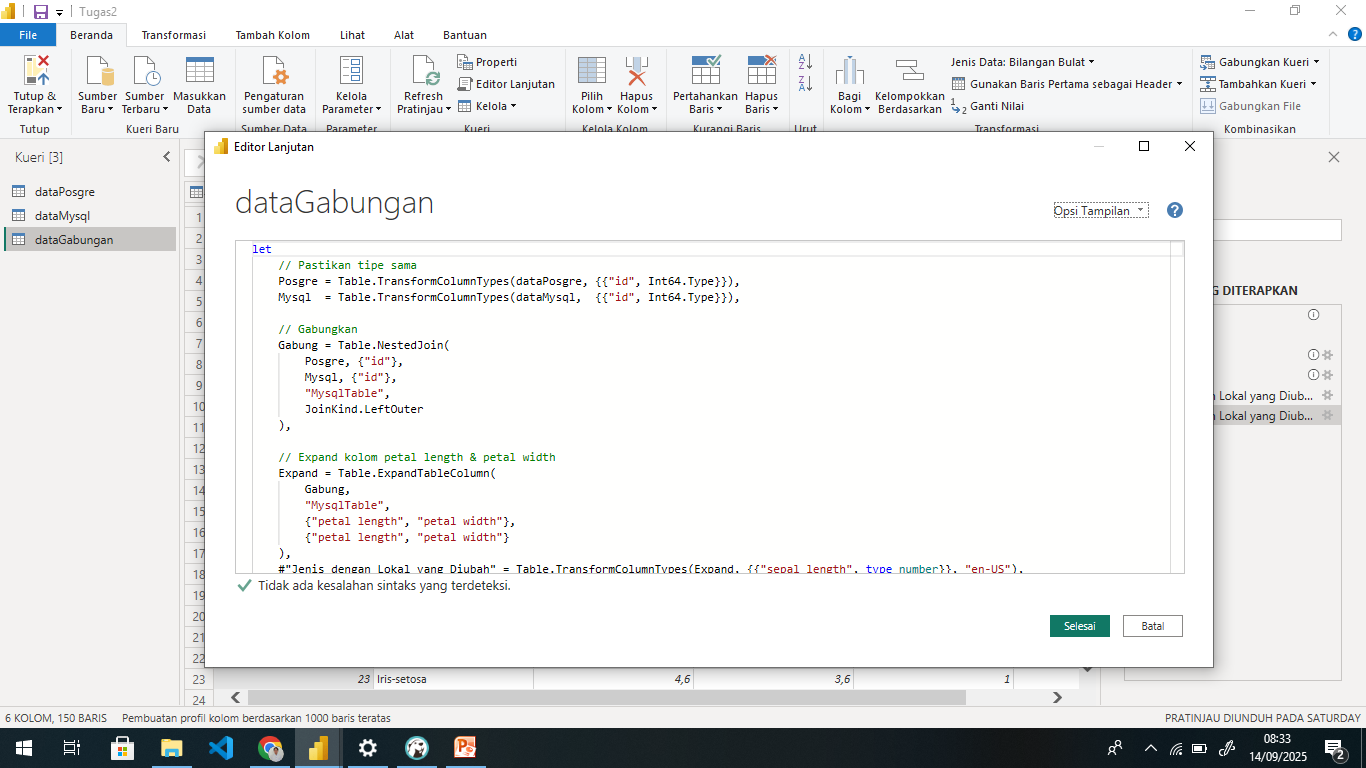

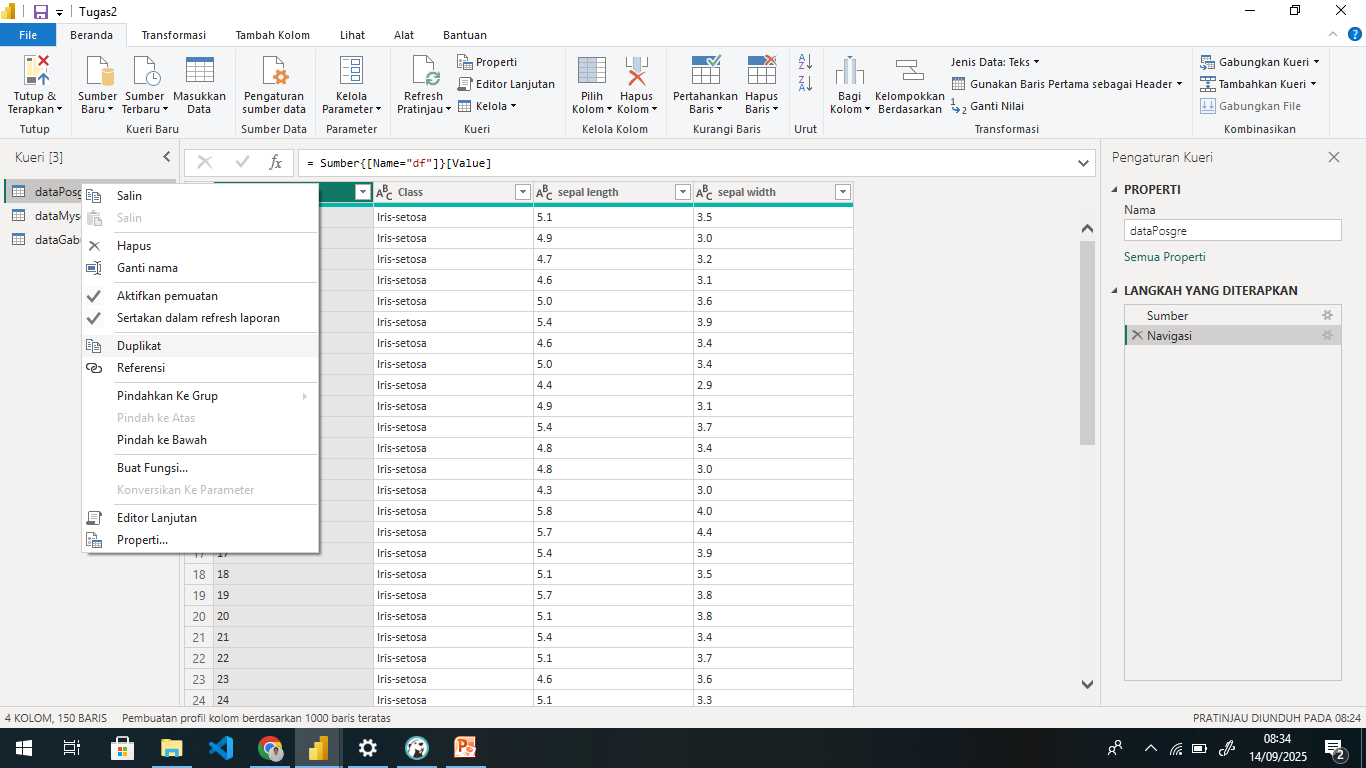

In [ ]:
let
    // Pastikan tipe sama
    Posgre = Table.TransformColumnTypes(dataPosgre, {{"id", Int64.Type}}),
    Mysql  = Table.TransformColumnTypes(dataMysql,  {{"id", Int64.Type}}),

    // Gabungkan
    Gabung = Table.NestedJoin(
        Posgre, {"id"},
        Mysql, {"id"},
        "MysqlTable",
        JoinKind.LeftOuter
    ),

    // Expand kolom petal length & petal width
    Expand = Table.ExpandTableColumn(
        Gabung,
        "MysqlTable",
        {"petal length", "petal width"},
        {"petal length", "petal width"}
    ),
    #"Jenis dengan Lokal yang Diubah" = Table.TransformColumnTypes(Expand, {{"sepal length", type number}}, "en-US"),
    #"Jenis dengan Lokal yang Diubah1" = Table.TransformColumnTypes(#"Jenis dengan Lokal yang Diubah", {{"sepal width", type number}}, "en-US")
in
    #"Jenis dengan Lokal yang Diubah1"

### Identifikasi Oulier menggunakan metode KNN

K-Nearest Neighbors (KNN) adalah algoritma berbasis kedekatan (proximity-based) yang digunakan dalam klasifikasi, regresi, dan deteksi outlier. Dalam konteks outlier detection, KNN menghitung jarak antara setiap titik data dan k tetangga terdekatnya. Jika suatu titik jauh dari tetangga-tetangganya, maka titik tersebut dianggap sebagai outlier.

#### Cara kerja KNN dalam deteksi Outlier

1. Menghitung jarak

Untuk setiap data dalam dataset, KNN menghitung jaraknya terhadap semua titik lain.
Umumnya menggunakan Euclidean Distance dengan menjumlahkan selisih dari setiap fitur antar titiknya:

$d(A, B) = \sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}$

Pada kasus ini, fitur yang digunakan:
* Sepal Length
* Sepal Width
* Petal Length
* Petal Width

2. Mencari k Tetangga Terdekat
Untuk setiap titik data,
* cari k tetangga terdekat (misalnya k = 3).
* Urutkan data berdasarkan distance dan ambil 3 tetangga terdekat.

3. Menghitung Rata-rata Jarak ke k Tetangga Terdekat
Untuk setiap titik

* hitung rata-rata jarak ke 3 tetangga terdekat:

$
R = \frac{d_1 + d_2 + d_3}{3}
$

* Semakin besar nilai rata-rata distance, semakin besar kemungkinan titik tersebut adalah outlier.

4. Menentukan Outlier

* Gunakan threshold berdasarkan nilai rata-rata distance dari semua titik.

* Outlier adalah data yang memiliki rata-rata jarak lebih besar dari threshold tertentu (misalnya di atas Q3 + 1.5 * IQR dalam boxplot).


1. Disini saya menggunakan pycaret untuk menghitung knn outliernya pastikan minimal versi pytho 3.11 kemudian duplicat data gabungan beri nama dataOutlier untuk menghasilkan table outlier salin code berikut lalu oke

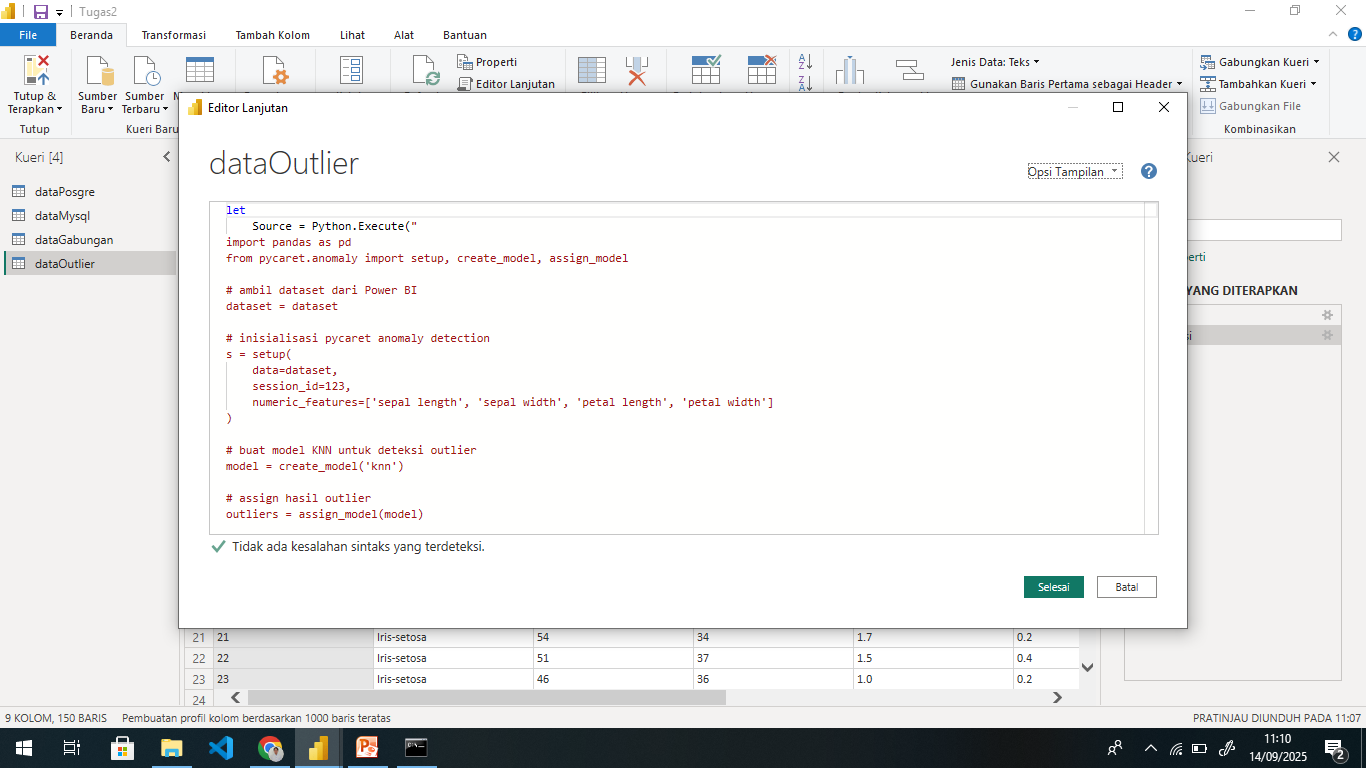

In [ ]:
let
    Source = Python.Execute("
import pandas as pd
from pycaret.anomaly import setup, create_model, assign_model

# ambil dataset dari Power BI
dataset = dataset

# inisialisasi pycaret anomaly detection
s = setup(
    data=dataset,
    session_id=123,
    numeric_features=['sepal length', 'sepal width', 'petal length', 'petal width']
)

# buat model KNN untuk deteksi outlier
model = create_model('knn')

# assign hasil outlier
outliers = assign_model(model)

# tambahkan label Yes/No
outliers['OutlierLabel'] = outliers['Anomaly'].apply(lambda x: 'Yes' if x == 1 else 'No')

outliers
", [dataset=dataGabungan]),
    Result = Source{[Name="outliers"]}[Value]
in
    Result

2. Maka akan muncul kolom baru yaitu anomaly dan scorenya dimaan nilai 1 yes menunjukkan outlier

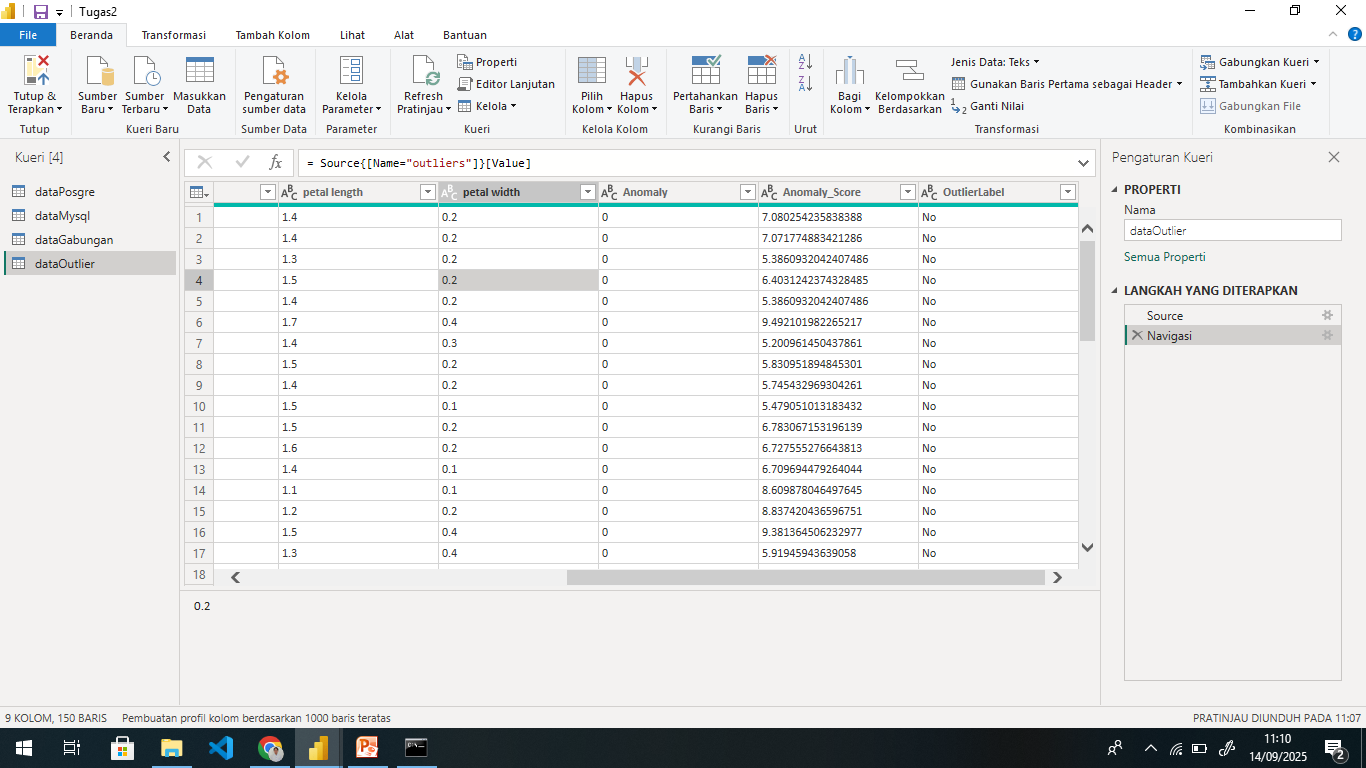

### Klastering menggunakan K-Means

K-Means adalah Teknik pengelompokan (clustering) berbasis partisi membagi data menjadi K kelompok berdasarkan jarak setiap kelompok direpresentasikan oleh centroid(rata-rata jarak dari titik dalam kluster) atau biasa disebut titik pusat suatu klaster.

Data yang sering kali tidak memiliki label-->Unsupervised learning clustering membantu mengelompokkan data berdasarkan kesamaan karakteristik

#### tujuan dan fungsi klustering

#### Tujuan dan Fungsi Klaster (Clustering)

**Clustering** adalah salah satu teknik utama dalam **unsupervised learning** yang bertujuan untuk mengelompokkan data berdasarkan kemiripan atau kedekatan karakteristik tanpa menggunakan label atau target output. Klastering sering digunakan dalam data mining, analisis data eksploratif, segmentasi pasar, dan banyak bidang lain.

---

##### 🎯 **Tujuan Klastering**

1. **Mengelompokkan Data Serupa**
   Tujuan utama klastering adalah mengelompokkan data ke dalam beberapa **kelompok (klaster)** sedemikian rupa sehingga:

   * Data dalam satu klaster **mirip** satu sama lain (intra-cluster similarity tinggi).
   * Data antar klaster **berbeda jauh** (inter-cluster dissimilarity tinggi).

2. **Reduksi Kompleksitas Data**
   Dengan membagi data ke dalam klaster, kita bisa menyederhanakan analisis data, terutama saat bekerja dengan data besar dan kompleks.

3. **Mengidentifikasi Pola atau Struktur Tersembunyi**
   Klastering dapat membantu mengungkap pola tersembunyi dalam data yang mungkin tidak tampak secara langsung.

4. **Segmentasi**
   Dalam dunia bisnis dan pemasaran, klastering digunakan untuk membagi pelanggan ke dalam segmen berdasarkan perilaku atau atribut tertentu (misalnya: segmentasi pelanggan, segmentasi wilayah, dll).

---

#### 🛠️ **Fungsi Klastering dalam Analisis Data**

| Fungsi                           | Penjelasan                                                                                          |
| -------------------------------- | --------------------------------------------------------------------------------------------------- |
| **Eksplorasi Data**              | Klaster membantu memahami struktur data, mendeteksi outlier, dan mengidentifikasi grup penting.     |
| **Pra-pemrosesan**               | Dapat digunakan sebelum algoritma supervised learning untuk menyaring atau mengelompokkan data.     |
| **Rekomendasi Sistem**           | Sistem rekomendasi sering menggunakan klastering untuk menemukan grup pengguna dengan minat serupa. |
| **Pengelompokan Dokumen / Teks** | Untuk mengelompokkan artikel, berita, atau dokumen berdasarkan topik utama.                         |
| **Deteksi Anomali**              | Data yang tidak masuk ke klaster manapun bisa dianggap sebagai anomali atau outlier.                |
| **Biologi / Genetika**           | Untuk mengelompokkan gen, ekspresi gen, atau jenis sel berdasarkan karakteristik biologis.          |


### Langkah Langkah Algoritma K-Means

1. Tentukan jumlah cluster
Disini saya akan mencoba dengan data yang ditampilkan membaginya dengan 2,3,4 klaster
2. Pilih K centroid awal secara acak setiap klaster memiliki 1 centroid
3. Hitung jarak setiap data ke tiap centroid
gunakan rumus Encludian Distance
$$
d(\mathbf{x}, \mathbf{c}) = \sqrt{ \sum_{i=1}^{n} (x_i - c_i)^2 }
$$


#### Penjelasan:

* $\mathbf{x} = (x_1, x_2, \ldots, x_n)$: vektor data.
* $\mathbf{c} = (c_1, c_2, \ldots, c_n)$: vektor centroid.
* $n$: jumlah dimensi atau fitur.
* $d(\mathbf{x}, \mathbf{c})$: jarak Euclidean antara data dan centroid.

4. Kelompokan data dengan centroid terdekat
5. Hitung ulang centroid dari rata rata anggota kluster
$$
\mu_k = \frac{1}{N_k} \sum_{x_i \in C_k} x_i
$$
#### ✅ Penjelasan:

* **\$\mu\_k\$**
  Menyatakan **centroid (titik pusat)** dari klaster ke-**\$k\$**.

* **\$N\_k\$**
  Jumlah **data (anggota)** yang terdapat dalam klaster ke-**\$k\$**.

* **\$x\_i \in C\_k\$**
  Menyatakan bahwa **\$x\_i\$** adalah titik data yang termasuk ke dalam klaster **\$C\_k\$**.

* **\$\sum\_{x\_i \in C\_k} x\_i\$**
  Menyatakan jumlah (penjumlahan vektor) dari seluruh titik data yang berada di dalam klaster **\$C\_k\$**.

* **\$\frac{1}{N\_k}\$**
  Digunakan untuk menghitung rata-rata dari semua anggota dalam klaster tersebut.

6. Ulangi langkah 3-5 hingga konvergen(tidak ada perubahan signifikan)



Pada Kolom sepal Length ini dibagi kedalam 4 klaster yaitu A,B,C,D

1. Duplikad data gabungan beri nama data klaster

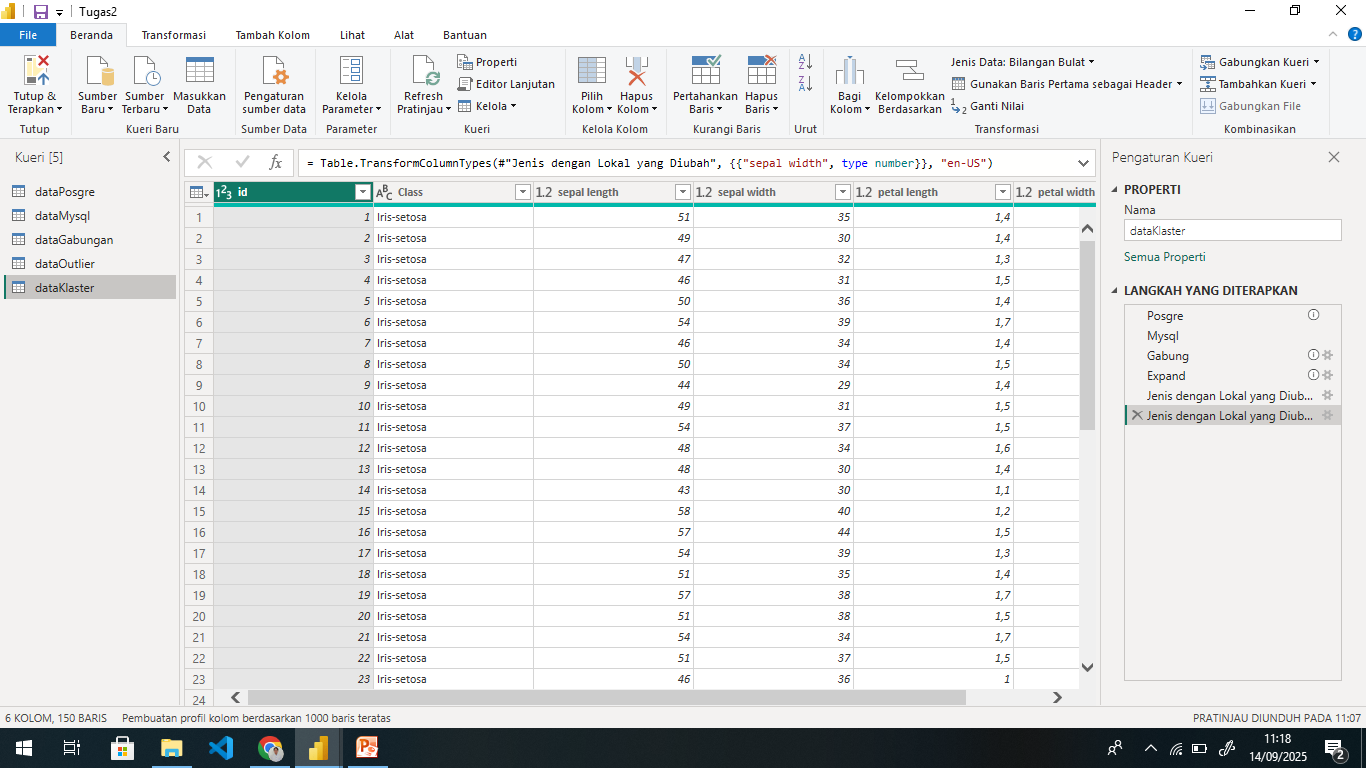

2. Lakukan hal yang sama dengan deteksi oulier menggunakan KNN

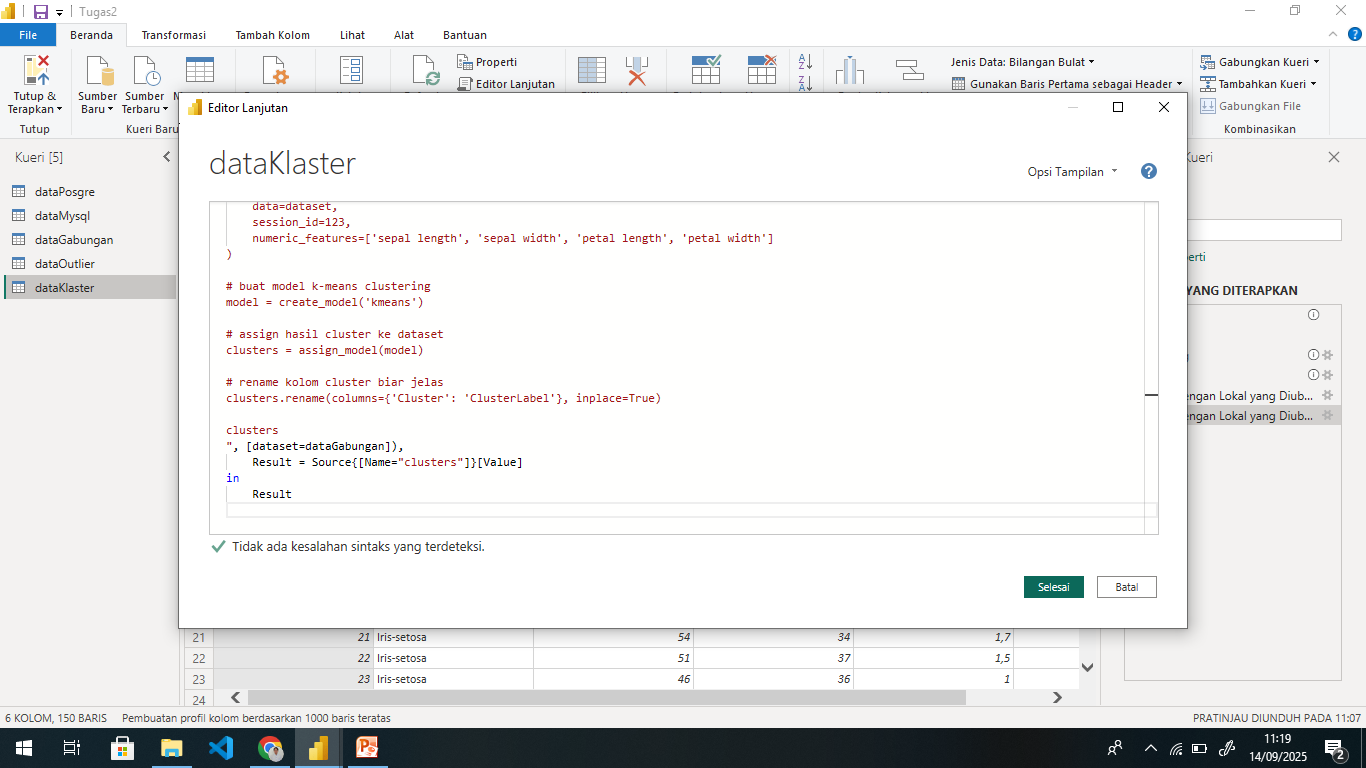

In [ ]:
let
    Source = Python.Execute("
import pandas as pd
from pycaret.clustering import setup, create_model, assign_model

# ambil dataset dari Power BI
dataset = dataset

# inisialisasi pycaret clustering
s = setup(
    data=dataset,
    session_id=123,
    numeric_features=['sepal length', 'sepal width', 'petal length', 'petal width']
)

# buat model k-means clustering
model = create_model('kmeans')

# assign hasil cluster ke dataset
clusters = assign_model(model)

# rename kolom cluster biar jelas
clusters.rename(columns={'Cluster': 'ClusterLabel'}, inplace=True)

clusters
", [dataset=dataGabungan]),
    Result = Source{[Name="clusters"]}[Value]
in
    Result


3. setelah klik selesai edit izin beri izin

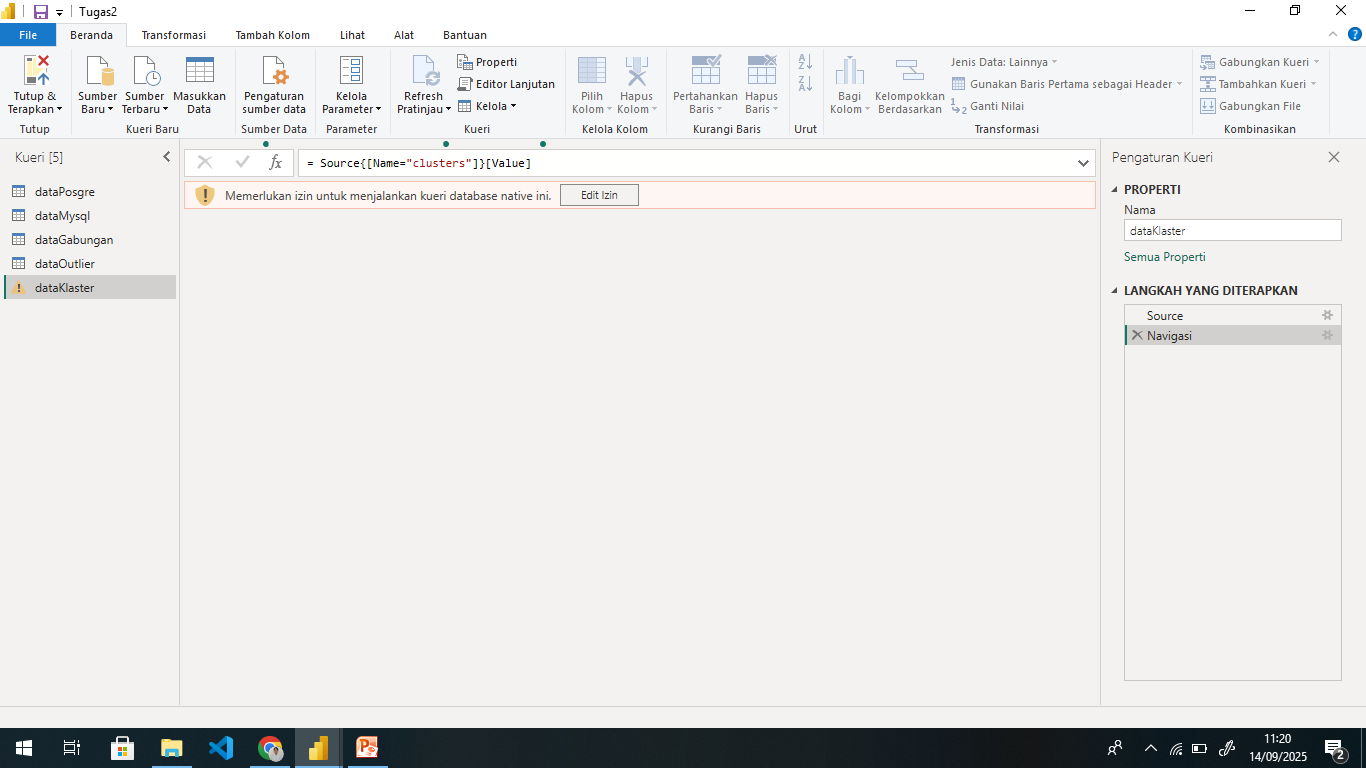

4. Setelah itu maka akan muncul tabel baru

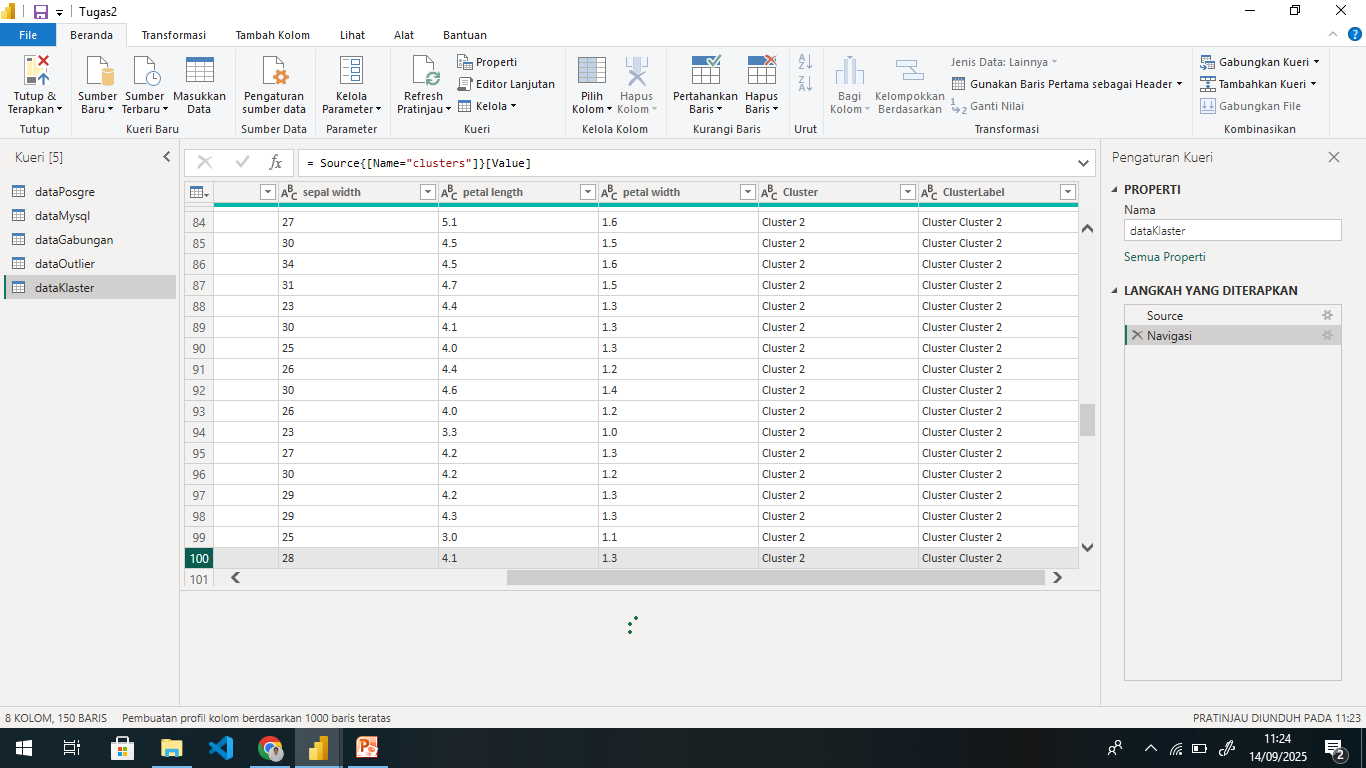